In [1]:
import pandas as pd
from pandas import Timestamp
import numpy as np
import scipy.stats as stats
from datetime import datetime
from pytz import timezone

import itertools

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

sns.set_style('whitegrid')
pd.set_option('display.max_columns', 100)

In [2]:
full_history = pd.read_json('data/history_comp.json')

if full_history['timestamp'].max().tz is None:
    full_history['timestamp'] = pd.to_datetime(full_history['timestamp'], utc=True)
    full_history['timestamp'] = full_history['timestamp'].apply(lambda t: t.tz_convert('US/Pacific'))

full_history = full_history.drop('index', axis=1)

As shown below, for every 2 songs listened to, 1 of them is unique and new to my music catalog.

In [3]:
def get_unique():
    drop_cols = ['timestamp']
    if 'weekday' in full_history.columns:
        drop_cols.extend(['weekday', 'hour_decimal'])
        
    unique_history = full_history.drop(drop_cols, axis=1)
    return unique_history.drop_duplicates('id')

len(full_history)/len(get_unique())

2.261246535427475

Here is a sample of artists. In addition to the a priori known name, we have followers, genres, and popularity of each artist.

In [4]:
artists = pd.read_json('data/artist_info.json')
artists.sample(5)

,artist,followers,genres,id,popularity
3843,Big Mack,227,[],6lRUscuxA2Lugzx3589qb7,41
523,Blake Hazard,426,[boston rock],1HgfGD7xhAr4cF3HBVL8p6,21
7832,Mr. Paradise,1341,[],4se6qBU0M2I86IER53xbYo,33
5115,Dae Zhen,1249,[],2DAlyzXQHghMi4v3bWQs8h,33
2416,If These Trees Could Talk,51563,"[instrumental post rock, post rock, post-metal]",2GVzsXcXyU95u2EahzwqN7,47


### Visualizing Feature Space

Below we visualize the distributions of each feature. Pay close attention because we do make some modifications on a per-feature basis. These are designed to reduce error down the road.

In [5]:
def hist(X, xlim, bins=14):
    plt.xlim(xlim)
    N, bins, patches = plt.hist(X, bins=bins)

    fracs = N / N.max()

    norm = colors.Normalize(fracs.min(), fracs.max())

    for frac, patch in zip(fracs, patches):
        color = plt.cm.coolwarm(norm(frac))
        patch.set_facecolor(color)

### Acousticness

A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

count    31818.000000
mean         0.305927
std          0.313991
min          0.000001
25%          0.039000
50%          0.184000
75%          0.514000
max          0.996000
Name: acousticness, dtype: float64

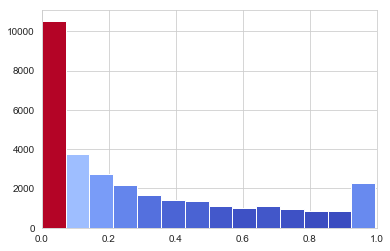

In [6]:
hist(full_history['acousticness'], [0,1])
full_history['acousticness'].describe()

### Danceability

Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

count    31818.000000
mean         0.596498
std          0.170409
min          0.000000
25%          0.482000
50%          0.606000
75%          0.723000
max          0.984000
Name: danceability, dtype: float64

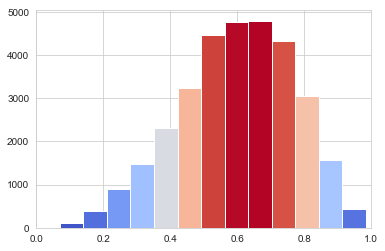

In [7]:
hist(full_history['danceability'], [0,1])
full_history['danceability'].describe()

### Duration

The duration of the track in milliseconds. Convert the duration to floating-point minutes.

count    31818.000000
mean         3.857636
std          1.463389
min          0.510367
25%          3.103333
50%          3.638775
75%          4.316667
max         41.983333
Name: duration, dtype: float64

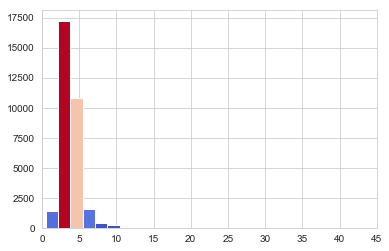

In [8]:
full_history['duration'] = full_history['duration_ms'] / 1000 / 60
hist(full_history['duration'], [0,45], 25)
full_history['duration'].describe()

In [9]:
full_history = full_history.drop('duration_ms', axis=1)

### Energy

Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

count    31818.000000
mean         0.585496
std          0.231184
min          0.000577
25%          0.447000
50%          0.605000
75%          0.757000
max          0.998000
Name: energy, dtype: float64

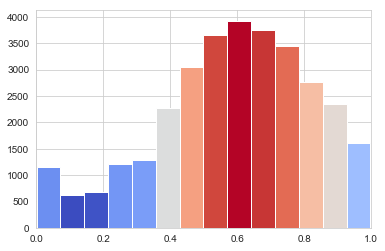

In [10]:
hist(full_history['energy'], [0,1])
full_history['energy'].describe()

### Liveness

Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

count    31818.000000
mean         0.188500
std          0.151333
min          0.017600
25%          0.097200
50%          0.124000
75%          0.231000
max          0.992000
Name: liveness, dtype: float64

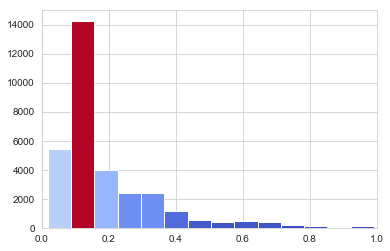

In [11]:
hist(full_history['liveness'], [0,1])
full_history['liveness'].describe()

In [12]:
full_history[full_history['liveness'] > 0.8].drop_duplicates('id')['name'][:15]

10014                                       Round Whippin'
10046                         Superhuman (feat. Eric Leva)
10071                                                 TEAM
10141                    Sunday Morning Coming Down - Live
10385                                              Feel Me
10422                                            Look Back
1065                              Fell In Love With A Girl
10665                                        Momma Told Me
10781                                           TEMPTATION
10919    Flick of the Wrist - Live at The Rainbow, Lond...
10923                           Get Down, Make Love - Live
10926                            God Save The Queen - Live
10966                                           So Special
10988                                      Ragged Old Flag
11296                                    Tourment d' amour
Name: name, dtype: object

Liveness is obviously an inaccurate measurement, thus we cannot use it reliably. We remove it.

In [13]:
full_history = full_history.drop('liveness', axis=1)

### Loudness

The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

Similar to duration, loudness is heavily skewed, thus we log scale it to bring things back together and reveal more of the underlying structure. Note the transformation of the values too. Since we don't care too much about the actual value of the loudness, only whether it's relatively loud or not, we assume this is acceptable.

count    31818.000000
mean         2.150760
std          0.459909
min         -0.529329
25%          1.859262
50%          2.116015
75%          2.379731
max          3.877990
Name: log_loudness, dtype: float64

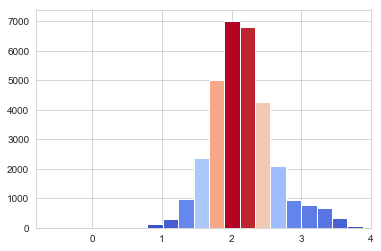

In [14]:
full_history['log_loudness'] = np.log(-1*full_history['loudness']+1)
hist(full_history['log_loudness'], [-0.8,4], 20)
full_history['log_loudness'].describe()

In [15]:
full_history = full_history.drop('loudness', axis=1)

### Popularity

The popularity of the track. The value will be between 0 and 100, with 100 being the most popular.
The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.

Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note that the popularity value may lag actual popularity by a few days: the value is not updated in real time.

count    31818.000000
mean        53.189704
std         17.636074
min          0.000000
25%         43.000000
50%         55.000000
75%         65.000000
max        100.000000
Name: popularity, dtype: float64

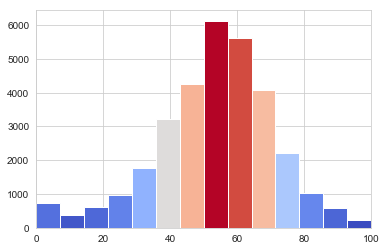

In [16]:
hist(full_history['popularity'], [0, 100])
full_history['popularity'].describe()

### Tempo

The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

count    31818.000000
mean       117.822648
std         30.121253
min          0.000000
25%         94.000000
50%        117.000000
75%        140.000000
max        222.000000
Name: tempo, dtype: float64

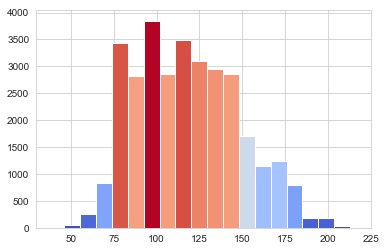

In [17]:
full_history['tempo'] = full_history['tempo'].apply(round)
hist(full_history['tempo'], [30, 225], 24)
full_history['tempo'].describe()

Many songs are misclassified by Spotify, often doubling the real BPM. Presto tempo is said to be above 168, and after looking through many of the resutls of songs above 168 BPM, it is reasonable to correct songs above this threshold. Although it does cut out the top end, it is more representative for  many songs.

In [18]:
full_history['tempo'] = full_history['tempo'].apply(lambda x: x if x < 168 else x/2)

### Valence

A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

count    31818.000000
mean         0.443361
std          0.241752
min          0.000000
25%          0.246000
50%          0.421000
75%          0.621000
max          0.990000
Name: valence, dtype: float64

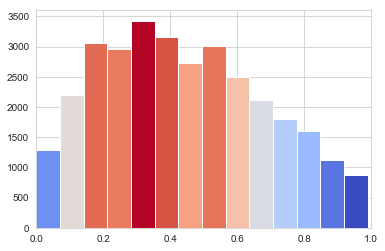

In [19]:
hist(full_history['valence'], [0, 1])
full_history['valence'].describe()

### Release Date

After examining, the release date isn't accurate either. For example, all classical music has release dates of 1960 or later, since this is the release of the album itself, not necessarily the conception of the music (which would have placed a lot of this genre in the 17th-20th centuries).

In [20]:
full_history = full_history.drop('release', axis=1)

Day and time of the week

In [21]:
def makeWeekday(a):
    '''
    weekday
    '''
    return a.weekday()

def makeDecimalHour(a):
    '''
    decimal hour
    '''
    return a.hour + (a.minute / 60.0)

In [22]:
full_history['weekday'] = full_history['timestamp'].apply(makeWeekday)

full_history['hour_decimal'] = full_history['timestamp'].apply(makeDecimalHour)

In [23]:
full_history.sample(5)

,acousticness,album,artists,danceability,energy,explicit,id,key,mode,name,popularity,speechiness,tempo,time_signature,timestamp,valence,duration,log_loudness,weekday,hour_decimal
19438,0.786,So Polite,[3MATPJ9tYbcMhw5VOZrRU6],0.788,0.2000,0,15z8ZeMZXrUrkO5ydZnSmo,2,0,So Polite,44,0.0288,106.0,4,2018-09-19 16:41:00-07:00,0.314,1.758517,2.502337,2,16.683333
26905,0.809,The Astaire Story,[4BtDAwCZhR6nPrJtbVgQNX],0.719,0.0879,0,5amzLSUX4V7Gszkd0bJnt5,9,1,I Love Louisa,14,0.3430,109.0,4,2018-09-04 20:57:00-07:00,0.521,2.722000,2.851804,1,20.950000
28004,0.255,Light of Mine,"[4qBgvVog0wzW75IQ48mU7v, 17lzZA2AlOHwCwFALHttm...",0.765,0.6090,1,2NWoKpRnMfxocVAXF8ASwk,1,0,Ikuyo (feat. 2 Chainz & Sophia Black),64,0.1900,78.0,4,2018-08-26 17:51:00-07:00,0.547,3.694450,1.838166,6,17.850000
18577,0.362,Couldn't Stand The Weather (Legacy Edition),[5fsDcuclIe8ZiBD5P787K1],0.475,0.3830,0,5XNpdKmlLJPUbwKQceX2tW,1,1,Little Wing,59,0.0375,115.0,4,2018-09-28 14:45:00-07:00,0.524,6.808000,2.721427,4,14.750000
31260,0.579,Heaven's Only Wishful,[63vaeIIBKIe9zT91EORVbr],0.542,0.4680,0,3mSDOXph5bbX3YfFIJLi64,10,1,Whatever Comes to Mind,56,0.0265,131.0,4,2018-11-23 11:14:00-08:00,0.252,4.155083,2.174297,4,11.233333


How much music are we talking about here?

In [24]:
total_hours = full_history['duration'].sum()/(60)
print('Total hours: {:0.3f}'.format(total_hours))

hours_per_day = total_hours/(full_history['timestamp'].max() - full_history['timestamp'].min()).days
print('Hours/day: {:0.1f}'.format(hours_per_day))

avg_song_dur = full_history['duration'].mean()
print('Average songs/day: {:0.0f}'.format(hours_per_day/(avg_song_dur/(60.0))))

print('Total songs listened to: {} (unique songs: {})'.format(len(full_history), len(get_unique())))

Total hours: 2045.704
Hours/day: 5.6
Average songs/day: 87
Total songs listened to: 31818 (unique songs: 14071)


## What kinds of music do I listen to?

First, what types of genres am I listening to?

In [25]:
artists_index = pd.Index(artists['id'])

def addTrackGenres(row):
    inner_gs = []
        
    # for each artist in a track
    for track_artist in row['artists']:
                        
        # if the artist exists, get its index
        try:
            i = artists_index.get_loc(track_artist)
        except KeyError:
            i = -1
            
        if i > -1:
            cell = artists.iloc[i, 2]
            if cell:
                # collect genres from artists that match the current index
                inner_gs.append(cell)
                
    if inner_gs:
        row['genres'] = np.unique(list(itertools.chain(*inner_gs)))
    else:
        row['genres'] = None
        
    return row

In [26]:
full_history = full_history.apply(addTrackGenres, 1)

In [27]:
genres = []
counts = []
freqs =  []
var1 =   []

for row in full_history.loc[full_history['genres'].notnull(), ['energy', 'genres']].itertuples():
    
    for genre in row.genres:
        
        if genre in genres:
            i = genres.index(genre)
            counts[i] += 1
            var1[i] += row.energy
        else:
            genres.append(genre)
            counts.append(1)
            var1.append(row.energy)

total = sum(counts)
freqs = np.array(counts) / total
var1 = np.array(var1) / np.array(counts)

collective_genres = pd.DataFrame({'freq': freqs, 'count': counts, 'genre': genres, 'var1': var1})

Below is a visualization of my top 25 genres, starting with most listened to.

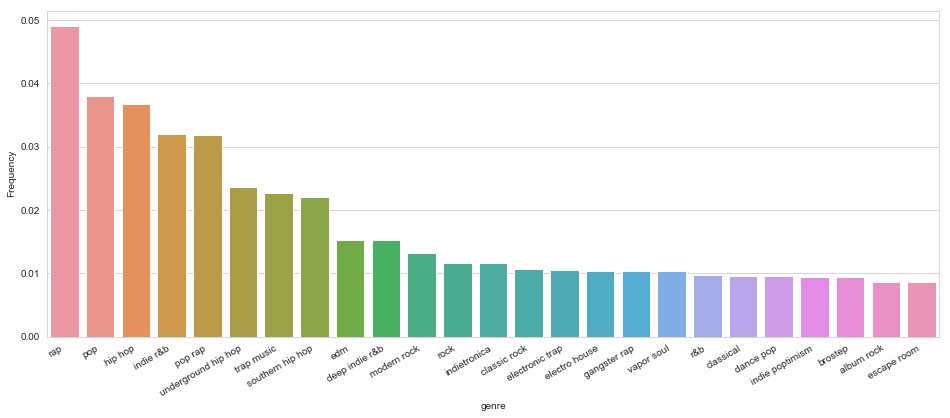

In [28]:
offset = 0
top = 25
sorted_collective_genres = collective_genres.sort_values('freq', ascending=False)

plt.subplots(figsize=(16, 6))
sns.barplot(x='genre', y='freq', data=sorted_collective_genres[offset:offset+top])
plt.ylabel('Frequency')
plt.xticks(rotation=30, ha='right');

What is the overall mood of my music collection like? It is skewed toward a sadder mood, and has a mean valence of 0.4, which isn't particularly happy.

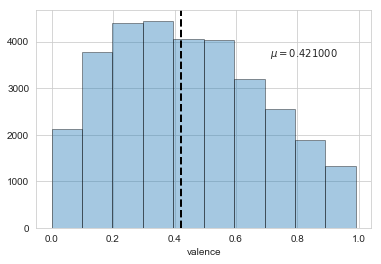

In [29]:
ax = sns.distplot(full_history.valence, bins=10, kde=False, hist_kws={"edgecolor": "k", "linewidth":1})
plt.axvline(full_history.valence.median(), color='k', linestyle='--', linewidth=2);
plt.text(0.8, 0.8, r'$\mu={0:2f}$'.format(full_history.valence.median()), 
         horizontalalignment='center', verticalalignment='center', transform=ax.transAxes);

Who are my most listened to artists?

In [30]:
collective_artists = [artists for artists in full_history.loc[full_history['artists'].notnull(), 'artists']]
    
collective_artists = np.array(list(itertools.chain(*collective_artists)))
unique_artists, artist_counts = np.unique(collective_artists, return_counts=True)

artist_df = pd.DataFrame({'id': unique_artists, 'listens': artist_counts})
artists = pd.merge(artist_df, artists, on='id')

def simplifyGenre(x):
    for genre in collective_genres['genre']:
        if genre in x:
            return genre
        
    return 'other'

artists['simple_genre'] = artists['genres'].apply(simplifyGenre)

Below is a visualization of my most listened to artists. They are counted if they are featured or produce a song as well. The color represents their top-level genre classification.

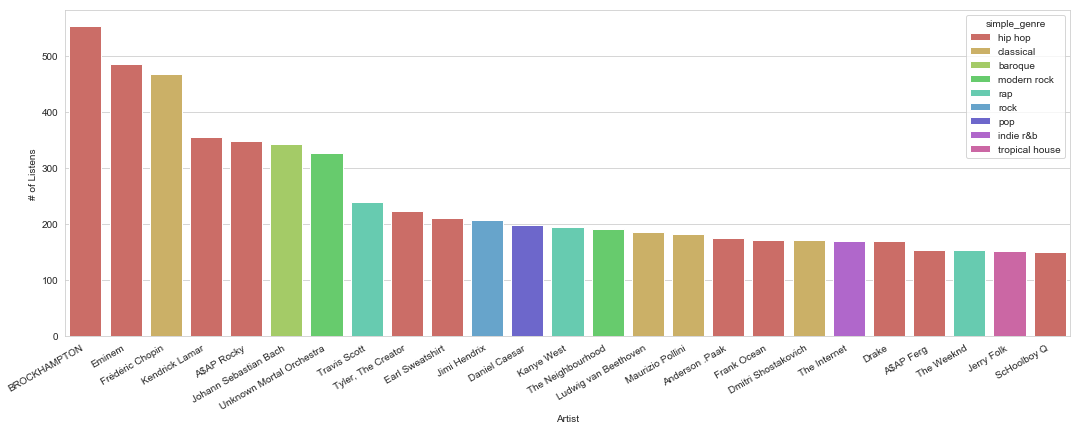

In [31]:
offset = 0
sort_artist_df = artists.sort_values('listens', ascending=False)

plt.subplots(figsize=(18,6))
g = sns.barplot(x='artist', y='listens', data=sort_artist_df[offset:offset+25], hue='simple_genre', dodge=False, palette='hls')
plt.xticks(rotation=30, horizontalalignment='right')
plt.xlabel('Artist');
plt.ylabel('# of Listens');
#plt.savefig('topartists.png')

In [32]:
full_history.to_json('data/history_clean.json')
artists.to_json('data/artists_clean.json')